# Data Preprocessing

In [ ]:
import numpy as np
train_x = np.load("train_x.npy")
train_y = np.load("train_y.npy")
test_x = np.load("test_x.npy")
test_y = np.load("test_y.npy")

In [2]:
from scipy import misc
train_x = train_x.reshape(60 * 8000, 101, 101)
test_x = test_x.reshape(60 * 2000, 101, 101)

In [3]:
new_train_x = []
for i in range(60 * 8000):
    new_train_x.append(misc.imresize(train_x[i], (128, 128)))

new_test_x = []
for i in range(60 * 2000):
    new_test_x.append(misc.imresize(test_x[i], (128, 128)))

In [4]:
train_x = np.asarray(new_train_x, dtype=np.uint8)
test_x = np.asarray(new_test_x, dtype=np.uint8)

In [9]:
train_x.reshape(8000 * 60, 128, 128)
test_x.reshape(2000 * 60, 128, 128)
train_x = np.asarray(train_x, dtype=np.uint8)
test_x = np.asarray(test_x, dtype=np.uint8)
train_x.shape, test_x.shape

((480000, 128, 128), (120000, 128, 128))

In [10]:
train_y = np.repeat(train_y, 60)
test_y = np.repeat(test_y, 60)
train_y = np.apply_along_axis(lambda x: 1 if x >= 20 else 0, 1, train_y.reshape(60 * 8000, 1))
test_y = np.apply_along_axis(lambda x: 1 if x >= 20 else 0, 1, test_y.reshape(60 * 2000, 1))
train_y = np.repeat(train_y, 2)
test_y = np.repeat(test_y, 2)

for i in range(0, 60 * 8000):
    if (train_y[2 * i] == 0):
        train_y[2 * i] = 1
    else:
        train_y[2 * i] = 0

for i in range(0, 60 * 2000):
    if (test_y[2 * i] == 0):
        test_y[2 * i] = 1
    else:
        test_y[2 * i] = 0

In [13]:
train_y = np.asarray(train_y, dtype=np.float32).reshape(60 * 8000, 2)
test_y = np.asarray(test_y, dtype=np.float32).reshape(60 * 2000, 2)

In [14]:
train_y.shape, test_y.shape

((480000, 2), (120000, 2))

In [6]:
import numpy as np
train_x = np.load("data/single_128/train_x.npy")
train_y = np.load("data/single_128/train_y.npy")
test_x = np.load("data/single_128/test_x.npy")
test_y = np.load("data/single_128/test_y.npy")
import tensorflow as tf

In [7]:
from sklearn.utils import shuffle
train_x, train_y = shuffle(train_x, train_y, random_state = 0)
test_x, test_y = shuffle(test_x, test_y, random_state = 0)

# Define CNN

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config)

In [2]:
n_input = 128 * 128
x = tf.placeholder(tf.uint8, shape=[None, 128, 128], name="x")
y_ = tf.placeholder(tf.float32, shape=[None, 2], name="y_")

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W ,strides=[1, 1, 1 ,1], padding="SAME")
def max_pool_4x4(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                         strides=[1, 4, 4, 1], padding="SAME")

# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 128, 128, 1])
float_x = tf.to_float(x_image)
h_conv1 = tf.nn.relu(conv2d(float_x, W_conv1) + b_conv1)
h_pool1 = max_pool_4x4(h_conv1)

# Secondary Convolution Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_4x4(h_conv2)

# Densely Connected Layer
W_fc1 = weight_variable([8 * 8 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8 * 8 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32, name="drop")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Read Layer
W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [3]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [4]:
sess.run(tf.global_variables_initializer())

## Training Data

In [8]:
import sys
train_size = 40
test_size = 100 
def get_batch_train(x, y, i, train_size):
    return x[i  * train_size: (i + 1) * train_size], y[i * train_size: (i + 1) * train_size]

def get_batch_test(x, y, i, test_size):
    return x[i * test_size: (i + 1) * test_size], y[i * test_size: (i + 1) * test_size]

total_train_iteration = len(train_x) / train_size
for i in range(120, 4000):
    if i % 10 == 0:
        saver = tf.train.Saver()
        save_path = saver.save(sess, "my_model/4_level_cnn/cnn", global_step=i)
    
    print("start evaluate")    
    total_iteration = len(test_x) / test_size
    total_accuracy = 0.0
    for test_batch_step in range(int(total_iteration)):
        test_batch_x, test_batch_y = get_batch_test(test_x, test_y, test_batch_step, test_size)
        total_accuracy += accuracy.eval(feed_dict={
            x:test_batch_x, y_: test_batch_y, keep_prob: 1.0}, session=sess)
    
    print("step %d, test accuracy %g"%(i, total_accuracy / total_iteration))
    
    for train_batch_step in range(int(total_train_iteration)):
        if train_batch_step % 400 == 0:
            str_log = ("%.2f %% " % (train_batch_step * 100 / total_train_iteration))
            sys.stdout.write('\r' + str_log)
        batch_x, batch_y = get_batch_train(train_x, train_y, train_batch_step, train_size)
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y, keep_prob: 0.5})

    

start evaluate
step 120, test accuracy 0.805767
0.00 % 

KeyboardInterrupt: 

In [4]:
saver = tf.train.Saver()
save_path = saver.save(sess, "my_model/4_level_cnn/cnn", global_step=119)

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/_0 = _Send[T=DT_FLOAT, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_43_Variable", _device="/job:localhost/replica:0/task:0/gpu:0"](Variable)]]
	 [[Node: Variable_1/Adam/_9 = _Recv[_start_time=0, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_47_Variable_1/Adam", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](^_recv_save/Const_0, ^save/SaveV2/tensor_names, ^save/SaveV2/shape_and_slices)]]

In [14]:
print(sess.run(W_conv1))
print(sess.run(W_conv2))
print(sess.run(b_conv1))
print(sess.run(b_conv2))
print(sess.run(W_fc1))
print(sess.run(W_fc2))
print(sess.run(b_fc1))
print(sess.run(b_fc2))

[[[[  1.48942277e-01  -1.32458076e-01  -8.62777382e-02  -2.40183249e-01
     -7.51394033e-02  -1.82100773e-01   3.26428041e-02  -1.77925736e-01
      1.00993693e-01  -2.86896881e-02  -5.19487932e-02   1.35306239e-01
      1.41272619e-01   1.53854981e-01   1.29648909e-01   1.81877837e-02
     -1.27498820e-01  -4.85454977e-01  -6.29177094e-02  -1.83078460e-02
      7.79257491e-02  -1.20260753e-01  -2.30817739e-02  -7.64074624e-02
     -1.06942534e-01   2.21564621e-02  -3.70716274e-01  -1.64416999e-01
     -1.85366105e-02   5.94032183e-02   6.12215288e-02  -1.00938573e-01]]

  [[ -5.47366105e-02   6.89673722e-02  -5.38763031e-02   9.43836868e-02
     -1.47698924e-01  -2.49080569e-01   7.96787441e-02  -8.35019574e-02
      2.39761546e-02   7.75716677e-02   8.18164572e-02  -2.19469383e-01
      3.50531116e-02  -1.05892695e-01  -1.92786381e-01   9.27374661e-02
      3.54943983e-02  -1.31568760e-01   2.25432646e-02  -2.69229221e-03
      2.65380573e-02  -2.29978133e-02   7.42000788e-02   5.36

In [9]:
print(sess.run(W_conv1))
print(sess.run(W_conv2))
print(sess.run(b_conv1))
print(sess.run(b_conv2))
print(sess.run(W_fc1))
print(sess.run(W_fc2))
print(sess.run(b_fc1))
print(sess.run(b_fc2))

[[[[  1.61277950e-01  -1.03597827e-01  -8.21181610e-02  -1.64960474e-01
     -1.76806971e-02  -1.04999423e-01  -1.72890630e-02  -1.17317267e-01
      7.72345811e-02  -1.40771633e-02  -9.19480771e-02   1.39006764e-01
      1.55608922e-01   1.27546430e-01   5.85935041e-02   4.12593149e-02
     -6.12786636e-02  -1.16753176e-01  -5.57242520e-02  -3.73498015e-02
      8.89571831e-02  -1.96736474e-02  -3.26627754e-02   6.26383722e-03
     -1.26160949e-01   1.58138741e-02  -2.01014206e-01   2.08894014e-02
      8.62071477e-03   6.49618581e-02   2.98394114e-02  -1.37827247e-01]]

  [[ -4.56362739e-02   1.07283860e-01  -4.17909585e-02   1.21200204e-01
     -6.87830523e-03  -1.36812925e-01   6.15417250e-02   1.23204906e-02
      2.93176714e-02   9.48994905e-02   8.18224102e-02  -1.81298748e-01
      7.08398074e-02  -1.28578335e-01  -1.10418558e-01   9.46243033e-02
      1.76013038e-02   2.70410422e-02  -1.62361972e-02  -1.89880766e-02
      4.66338620e-02   5.71819320e-02   6.92447200e-02  -5.39

## Test Data

In [22]:
import numpy as np
test_x_noshuffle = np.load("test_x.npy")
test_y_noshuffle = np.load("test_y.npy")
import tensorflow as tf

### [Optional] Restore Model

In [4]:
saver = tf.train.Saver()
saver.restore(sess, "my_model/4_level_cnn/cnn-119")

In [23]:
from scipy import misc
total_equal = 0
for i in range(2000):
    test_batch_x = test_x_noshuffle[i].reshape(60, 101, 101)
    temp_list = []
    for j in range(60):
        temp_list.append(misc.imresize(test_batch_x[j], (128, 128)))
    test_batch_x = np.asarray(temp_list, dtype=np.uint8)
    test_results = sess.run(y_conv, feed_dict={x: test_batch_x, keep_prob: 1.0})
    test_results = np.apply_along_axis(lambda x: np.argmax(x), 1, test_results)
    zero_num = (test_results == 0).sum()
    one_num = (test_results == 1).sum()
    print("%d online, zero num: %d, one num: %d" % (i, zero_num, one_num))
    if zero_num > one_num and test_y_noshuffle[i] < 20:
        total_equal += 1
    if zero_num < one_num and test_y_noshuffle[i] >= 20:
        total_equal += 1

print(total_equal / 2000.0)

0 online, zero num: 0, one num: 60
1 online, zero num: 43, one num: 17
2 online, zero num: 60, one num: 0
3 online, zero num: 57, one num: 3
4 online, zero num: 57, one num: 3
5 online, zero num: 56, one num: 4
6 online, zero num: 4, one num: 56
7 online, zero num: 60, one num: 0
8 online, zero num: 60, one num: 0
9 online, zero num: 59, one num: 1
10 online, zero num: 18, one num: 42
11 online, zero num: 60, one num: 0
12 online, zero num: 9, one num: 51
13 online, zero num: 23, one num: 37
14 online, zero num: 19, one num: 41
15 online, zero num: 60, one num: 0
16 online, zero num: 16, one num: 44
17 online, zero num: 0, one num: 60
18 online, zero num: 60, one num: 0
19 online, zero num: 60, one num: 0
20 online, zero num: 20, one num: 40
21 online, zero num: 60, one num: 0
22 online, zero num: 58, one num: 2
23 online, zero num: 60, one num: 0
24 online, zero num: 18, one num: 42
25 online, zero num: 42, one num: 18
26 online, zero num: 5, one num: 55
27 online, zero num: 59, one n

In [8]:
from scipy import misc
total_equal = 0
label_test_y = []
for i in range(2000):
    test_batch_x = test_x_noshuffle[i].reshape(60, 101, 101)
    temp_list = []
    for j in range(60):
        temp_list.append(misc.imresize(test_batch_x[j], (128, 128)))
    test_batch_x = np.asarray(temp_list, dtype=np.uint8)
    test_results = sess.run(y_conv, feed_dict={x: test_batch_x, keep_prob: 1.0})
    test_results = np.apply_along_axis(lambda x: np.argmax(x), 1, test_results)
    zero_num = (test_results == 0).sum()
    one_num = (test_results == 1).sum()
    label_test_y.append(0.0 if zero_num >= one_num else 1.0)

np.save("data/label_test_y", label_test_y)
print(total_equal / 2000.0)

0.0


In [9]:
label_test_y

[1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0

In [13]:
total_equal = 0
for i in range(2000):
    label = 1.0 if test_y_noshuffle[i] > 20 else 0
    if label_test_y[i] == label:
        total_equal += 1
print(total_equal / 2000.)

0.8585


## Online Data

In [9]:
import numpy as np
online_test_x = np.load("online_test_x.npy")

In [4]:
saver = tf.train.Saver()
saver.restore(sess, "my_model/4_level_cnn/cnn-119")

In [21]:
from scipy import misc
online_label_y = []
for i in range(2000):
    test_batch_x = online_test_x[i].reshape(60, 101, 101)
    temp_list = []
    for j in range(60):
        temp_list.append(misc.imresize(test_batch_x[j], (128, 128)))
    test_batch_x = np.asarray(temp_list, dtype=np.uint8)
    test_results = sess.run(y_conv, feed_dict={x: test_batch_x, keep_prob: 1.0})
    test_results = np.apply_along_axis(lambda x: np.argmax(x), 1, test_results)
    zero_num = (test_results == 0).sum()
    one_num = (test_results == 1).sum()
    print("%d online, zero num: %d, one num: %d" % (i, zero_num, one_num))
    online_label_y.append(0.0 if zero_num >= one_num else 1.0)

np.save("data/online_label_y", online_label_y)

0 online, zero num: 39, one num: 21
1 online, zero num: 56, one num: 4
2 online, zero num: 58, one num: 2
3 online, zero num: 53, one num: 7
4 online, zero num: 48, one num: 12
5 online, zero num: 50, one num: 10
6 online, zero num: 55, one num: 5
7 online, zero num: 56, one num: 4
8 online, zero num: 52, one num: 8
9 online, zero num: 56, one num: 4
10 online, zero num: 57, one num: 3
11 online, zero num: 60, one num: 0
12 online, zero num: 51, one num: 9
13 online, zero num: 57, one num: 3
14 online, zero num: 57, one num: 3
15 online, zero num: 54, one num: 6
16 online, zero num: 54, one num: 6
17 online, zero num: 58, one num: 2
18 online, zero num: 46, one num: 14
19 online, zero num: 45, one num: 15
20 online, zero num: 59, one num: 1
21 online, zero num: 46, one num: 14
22 online, zero num: 49, one num: 11
23 online, zero num: 58, one num: 2
24 online, zero num: 55, one num: 5
25 online, zero num: 54, one num: 6
26 online, zero num: 59, one num: 1
27 online, zero num: 50, one nu

In [20]:
online_label_y = np.asarray(online_label_y)
online_label_y[online_label_y == 0.0].shape

(1974,)

## Convert to Feature Vectors

In [12]:
import numpy as np
train_x_noshuffle = np.load("train_x.npy")

In [13]:
del train_x, train_y, test_x, test_y

In [33]:
from scipy import misc
temp_list = []
for i in range(8000):
    train_x_noshuffle_i = train_x_noshuffle[i].reshape(60, 101, 101)
    temp = []
    for image in train_x_noshuffle_i:
        temp.append(misc.imresize(image, (128, 128)))
    temp_list.append(np.asarray(temp, dtype=np.uint8).reshape(60, 128, 128))
train_x_noshuffle = temp_list

In [54]:
len(train_x_noshuffle)

8000

In [58]:
feature_train_x = []
for images in train_x_noshuffle:
    feature_train_x.append(sess.run(h_fc1, feed_dict={x: images}).reshape(1,1024*60))

print(len(feature_train_x))
print(feature_train_x[0].shape)
np.save("data/single_128/train_feature_x", feature_train_x)

8000
(1, 61440)


In [59]:
test_x_noshuffle = np.load("test_x.npy")
online_x = np.load("online_test_x.npy")

from scipy import misc
temp_list = []
for i in range(2000):
    test_x_noshuffle_i = test_x_noshuffle[i].reshape(60, 101, 101)
    temp = []
    for image in train_x_noshuffle_i:
        temp.append(misc.imresize(image, (128, 128)))
    temp_list.append(np.asarray(temp, dtype=np.uint8).reshape(60, 128, 128))
test_x_noshuffle = temp_list

temp_list = []
for i in range(2000):
    online_x_i = online_x[i].reshape(60, 101, 101)
    temp = []
    for image in train_x_noshuffle_i:
        temp.append(misc.imresize(image, (128, 128)))
    temp_list.append(np.asarray(temp, dtype=np.uint8).reshape(60, 128, 128))
online_x = temp_list

In [61]:
print(len(test_x_noshuffle), test_x_noshuffle[0].shape)
print(len(online_x), online_x[0].shape)

2000 (60, 128, 128)
2000 (60, 128, 128)


In [62]:
feature_test_x = []
for images in test_x_noshuffle:
    feature_test_x.append(sess.run(h_fc1, feed_dict={x: images}).reshape(1,1024*60))
    
print(len(feature_test_x))
print(feature_test_x[0].shape)
np.save("data/single_128/test_feature_x", feature_test_x)

feature_online_x = []
for images in online_x:
    feature_online_x.append(sess.run(h_fc1, feed_dict={x: images}).reshape(1,1024*60))
    
print(len(feature_online_x))
print(feature_online_x[0].shape)
np.save("data/single_128/online_feature_x", feature_online_x)

2000
(1, 61440)
2000
(1, 61440)


### Feature Visualization

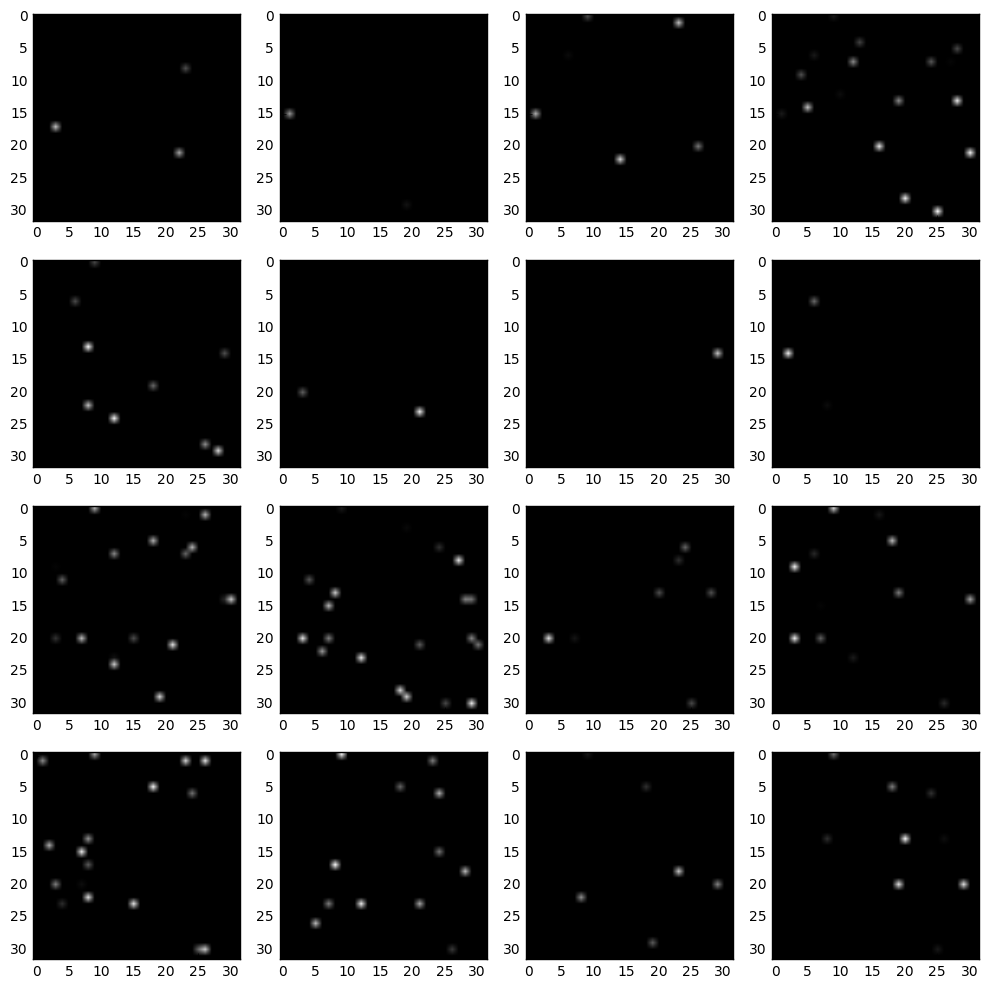

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
sample_data = train_x_noshuffle[0]
f, axarr = plt.subplots(4, 4, figsize=(10,10))
for row in range(4):
    for line in range(4):
        src_image = sample_data[row * 15 + line].reshape(1,128,128)
        feature_map = sess.run(h_fc1, feed_dict={x: src_image})[0].reshape(1,1024)
        feature_map = (feature_map / feature_map.max()) * 255.0
        axarr[row][line].imshow(np.apply_along_axis(lambda x: np.repeat(x, 3), 1, feature_map).reshape(32,32,3))

plt.tight_layout()
plt.show()

# Boosting

In [2]:
import numpy as np
feature_train_x = np.load("data/single_128/feature_train_x.npy")
train_y = np.load("train_y.npy")
feature_test_x = np.load("data/single_128/feature_test_x.npy")
test_y = np.load("test_y.npy")

In [3]:
feature_train_x = feature_train_x.reshape(8000, 1024 * 60)
feature_test_x = feature_test_x.reshape(2000, 1024 * 60)

In [4]:
train_y = np.asarray(train_y).reshape(8000)
test_y = np.asarray(test_y).reshape(2000)

In [5]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [7]:
reg = LGBMRegressor(max_depth=11)
model = reg.fit(feature_train_x, train_y)

In [27]:
reg_results = reg.predict(feature_test_x)
print("rsem")
np.sqrt(np.mean(np.square(np.array(reg_results) - np.array(test_y))))

rsem


15.984927290703242

In [9]:
import pandas as pd 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E78AB0438>]], dtype=object)

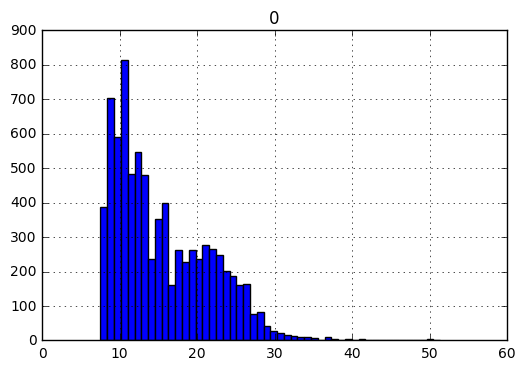

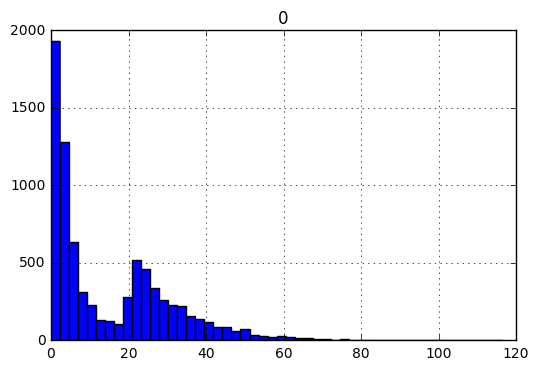

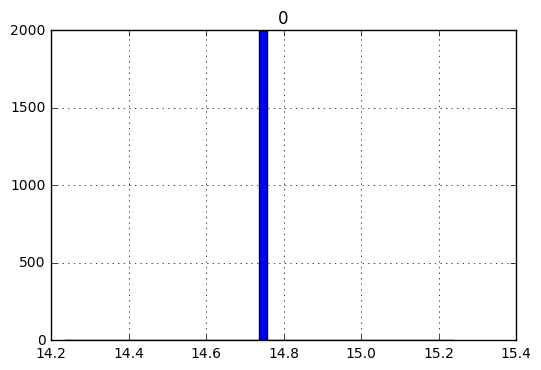

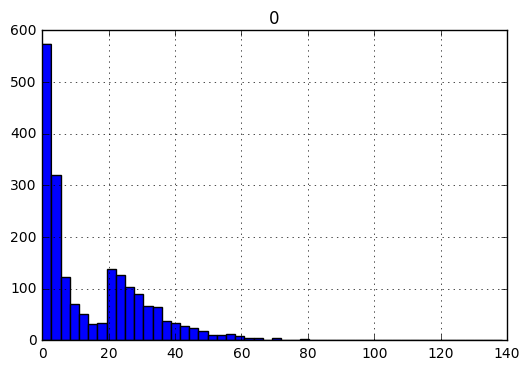

In [10]:
%matplotlib inline
reg_results = reg.predict(feature_train_x)
pd.DataFrame(reg_results).hist(bins=50)
pd.DataFrame(train_y).hist(bins=50)
reg_results = reg.predict(feature_test_x)
pd.DataFrame(reg_results).hist(bins=50)
pd.DataFrame(test_y).hist(bins=50)